In [1]:
# set cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4" #"1"
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Hypothesis Testing Circuits

The primary tests we want to replicate are the faithfulness test (Equiavelance) and the minimality test (Minimality)

Faithfulness Test
- the full model and ablated model are equally likely to outpeform each other on a task
    - probability of the delta of the score function is greater then 0 - 1/2 is less than epsilon
    - use a sign test
    - test statistic is the # of times C* and M outperform each other 
    - test statistic is absolue value of the difference between the mean that the ablated model outpeforms the original model and 1/2
- P value (value of test statistic such that P(T > T_obs) = alpha) given by binomial distribution P(K > (T_obs + 1/2) * n | \theta = (1/2) + \epsilon)
    how do we choose epsilon?
    set to 0.1



# Minimal Faithful Circuit According to Attribution Score Ordering

In [1]:
from typing import Callable, Dict, Tuple, Union, Optional, Any, Literal, NamedTuple
from itertools import product
from copy import deepcopy
import random
import math
from collections import defaultdict

import torch
import numpy as np
from scipy.stats import binom, beta

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from transformer_lens import HookedTransformer

from auto_circuit.types import (
    CircuitOutputs, 
    BatchKey,
    PruneScores,
    PatchType, 
    AblationType,
    SrcNode, 
    DestNode, 
    Edge,
    Node
)
from auto_circuit.data import PromptPairBatch, PromptDataLoader   
from auto_circuit.prune_algos.mask_gradient import mask_gradient_prune_scores
from auto_circuit.tasks import (
    Task,
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK,
    IOI_COMPONENT_CIRCUIT_TASK, 
    IOI_TOKEN_CIRCUIT_TASK,
    IOI_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK,
    GREATERTHAN_COMPONENT_CIRCUIT_TASK,  
    GREATERTHAN_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    CAPITAL_CITIES_PYTHIA_70M_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    docstring_true_edges
)
from auto_circuit.visualize import draw_seq_graph
from auto_circuit.utils.tensor_ops import batch_answer_diffs, batch_avg_answer_val
from auto_circuit.utils.patchable_model import PatchableModel
from auto_circuit.utils.custom_tqdm import tqdm

from elk_experiments.auto_circuit.auto_circuit_utils import (
    run_circuits,
    desc_prune_scores, 
    prune_scores_threshold, 
    load_tf_model
)
from elk_experiments.auto_circuit.score_funcs import GradFunc, AnswerFunc, get_score_func

from elk_experiments.auto_circuit.circuit_hypotests import (
    equiv_test,
    sweep_search_smallest_equiv,
    plot_equivs_bar, 
    plot_num_ablated_C_gt_M, 
    plot_circuit_and_model_scores,
    compute_knees, 
    plot_edge_scores_and_knees,
    create_paths, 
    minimality_test, 
    plot_p_values, 
    plot_edge_k, 
    plot_score_quantiles
)
from elk_experiments.auto_circuit.circuit_hypotests import (
    get_edge_idx,
    make_complement_paths, 
    edges_from_mask, 
    minimality_test
)


NodeIdx = Tuple[int, int] # layer, head
def get_node_idx(node: DestNode) -> NodeIdx:
    return (node.layer, node.head_idx)

In [2]:

DOCSTRING_PYTHIA_70M_AUTOENCODER_COMPONENT_CIRCUIT_TASK: Task = Task(
    key="Docstring Component Circuit",
    name="Docstring",
    _model_def="pythia-70m-deduped",
    _dataset_name="docstring_prompts",
    batch_size=2,
    batch_count=128,
    _true_edge_func=None,
    token_circuit=False,
    autoencoder_input="resid_delta_mlp",
    autoencoder_max_latents=200,
    autoencoder_pythia_size="2_32768",
    autoencoder_prune_with_corrupt=False,
)

from auto_circuit.metrics.official_circuits.circuits.ioi_official import (
    ioi_head_based_official_edges,
    ioi_true_edges,
)
IOI_TOKEN_CIRCUIT_TASK: Task = Task(
    key="Indirect Object Identification Token Circuit",
    name="Indirect Object Identification",
    _model_def="gpt2-small",
    _dataset_name="ioi/ioi_vanilla_template_prompts",
    batch_size=(60, 20),
    batch_count=(5, 5),
    _true_edge_func=ioi_head_based_official_edges,
    token_circuit=True,
)

In [3]:
task = DOCSTRING_TOKEN_CIRCUIT_TASK
token = task.token_circuit

task.init_task()

# docstring_task = DOCSTRING_COMPONENT_CIRCUIT_TASK
ablation_type = AblationType.TOKENWISE_MEAN_CLEAN_AND_CORRUPT
clean_corrupt = "corrupt" if ablation_type == AblationType.RESAMPLE else None 
alpha = 0.05
epsilon = -0.3 
q_star = 0.9
use_abs = True
side = None if use_abs else "left"
eg_min_layer = 3 # 21 for IOI
sg_max_layer = 2 # 3 for IOI
grad_function = GradFunc.LOGPROB if not use_abs else GradFunc.LOGIT
answer_function = AnswerFunc.AVG_VAL if not use_abs else AnswerFunc.AVG_DIFF
grad_function_attrib = grad_function
answer_function_attrib = answer_function

Loaded pretrained model attn-only-4l into HookedTransformer
seq_len before divergence 41
seq_len after divergence 30


In [4]:
# compute edge scores
# TODO: pass full model
attribution_scores = mask_gradient_prune_scores(
    model=task.model, 
    dataloader=task.train_loader,
    official_edges=None,
    grad_function=grad_function_attrib.value, #grad_function,
    answer_function=answer_function_attrib.value, #answer_function,
    mask_val=None, 
    ablation_type=ablation_type,
    integrated_grad_samples=10, # 10 1 for debugging
    clean_corrupt=clean_corrupt,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [5]:
test_results, min_equiv = sweep_search_smallest_equiv(
    task.model, 
    task.test_loader,
    attribution_scores,
    grad_function, 
    answer_function,
    ablation_type=ablation_type,
    use_abs=use_abs,
    side=side,
    alpha=alpha,
    epsilon=epsilon,
)

interval: 0 - 38430
width 1000


KeyboardInterrupt: 

In [7]:
assert min_equiv == min([k for k, v in test_results.items() if not v.not_equiv])
min_equiv

34

In [8]:
threshold = prune_scores_threshold(attribution_scores, min_equiv, use_abs=use_abs)
edge_mask = {k: torch.abs(v) if use_abs else v >= threshold for k, v in attribution_scores.items()}
edges = edges_from_mask(task.model.srcs, task.model.dests, edge_mask, token=task.token_circuit)


In [9]:
# accuracy, true positive
overlap = set(edges) & set(task.true_edges)
acc = len(overlap) / task.true_edge_count
tp = len(overlap) / len(edges)
acc, tp

(0.003833443489755453, 0.8529411764705882)

In [10]:
# create edge dicts by src and dest
edges_by_dest: dict[NodeIdx, list[Edge]] = defaultdict(list)
edges_by_src: dict[NodeIdx, list[Edge]] = defaultdict(list)
for edge in edges:
    edges_by_dest[get_node_idx(edge.dest)].append(edge)
    edges_by_src[get_node_idx(edge.src)].append(edge)
# creates edges to dest list
edges_to_dest: list[Edge] = []
# create edges to check queue
edges_to_check: list[Edge] = []
# add all edges with dest at resid end to edges to check
resid_end = next((dest for dest in task.model.dests if dest.name == "Resid End"), None)
edges_to_check.extend(edges_by_dest[get_node_idx(resid_end)])
checked: set[Node] = set()
# while len(edges_to_check) > 0
while len(edges_to_check) > 0:
    edge = edges_to_check.pop(0)
    # add edge to edges to dest
    edges_to_dest.append(edge)
    # get all edges with dest as src and add to edges to check (if not already chchedk)
    if edge.src in checked:
        continue
    for edge_to_check in edges_by_dest[get_node_idx(edge.src)]:
        # filter for queries not in same sequence 
        if (edge_to_check.dest.name.endswith("Q") or edge_to_check.dest.name.startswith("MLP")) and edge.seq_idx != edge_to_check.seq_idx:
            continue
        edges_to_check.append(edge_to_check)
    checked.add(edge.src)
print(len(edges_to_dest), len(edges))


24 34


In [ ]:
edges_to_dest_set = set(edges_to_dest)
complement_edges = {edge for edge in task.model.edges if edge not in edges_to_dest_set}

In [11]:
# mask out all edges not in edges to dest
dead_end_score_mask = deepcopy(attribution_scores)
for edge in set(edges) - set(edges_to_dest):
    dead_end_score_mask[edge.dest.module_name][get_edge_idx(edge, tokens=task.token_circuit)] = 0.0

In [12]:
# from elk_experiments.auto_circuit.circuit_hypotests import equiv_test
# recompute equivalence 
pruned_result = equiv_test(
    task.model, 
    task.test_loader,
    dead_end_score_mask,
    grad_function,
    answer_function,
    ablation_type,
    thresholds=[threshold],
    model_out=None,
    full_model=None,
    use_abs=use_abs,
    side=side,
    alpha=alpha,
    epsilon=epsilon,
)[len(edges_to_dest)]

In [13]:
assert not pruned_result.not_equiv
assert torch.allclose(pruned_result.circ_scores, test_results[len(edges)].circ_scores, atol=1e-4)

In [14]:
fig = draw_seq_graph(
    model=task.model,
    prune_scores=dead_end_score_mask,
    score_threshold=prune_scores_threshold(attribution_scores, min_equiv, use_abs=use_abs),
    show_all_seq_pos=True,
    orientation="h",
    use_abs=False,
    seq_labels=task.test_loader.seq_labels,
)

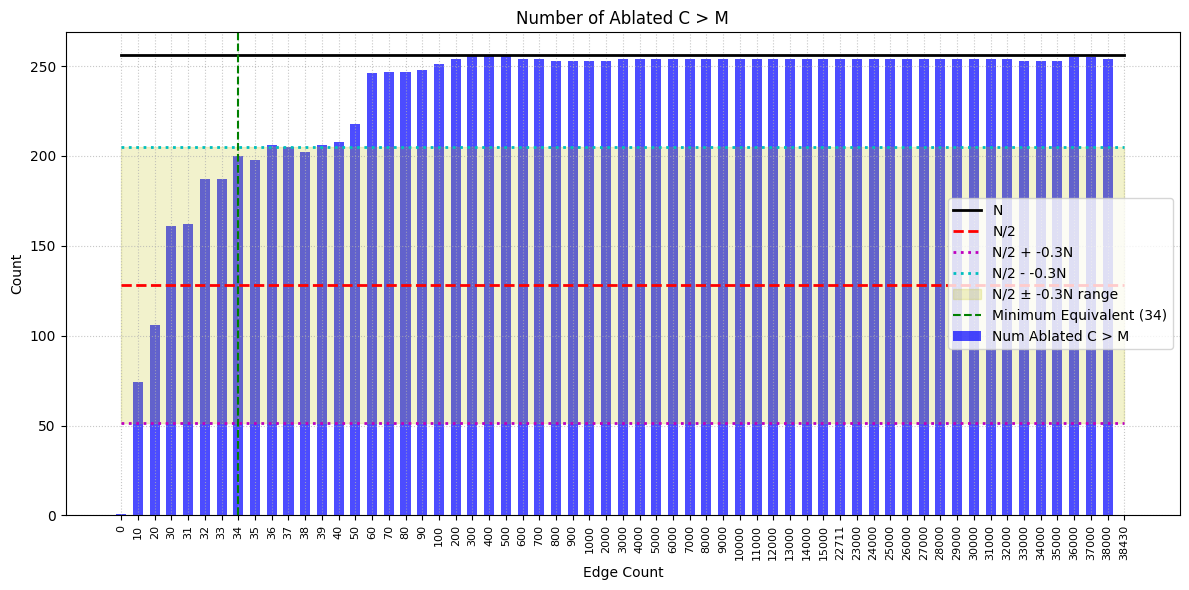

In [21]:
#TODO: fix to allow for negative epsilon
fig, ax = plot_num_ablated_C_gt_M(test_results, epsilon=epsilon, min_equiv=min_equiv)

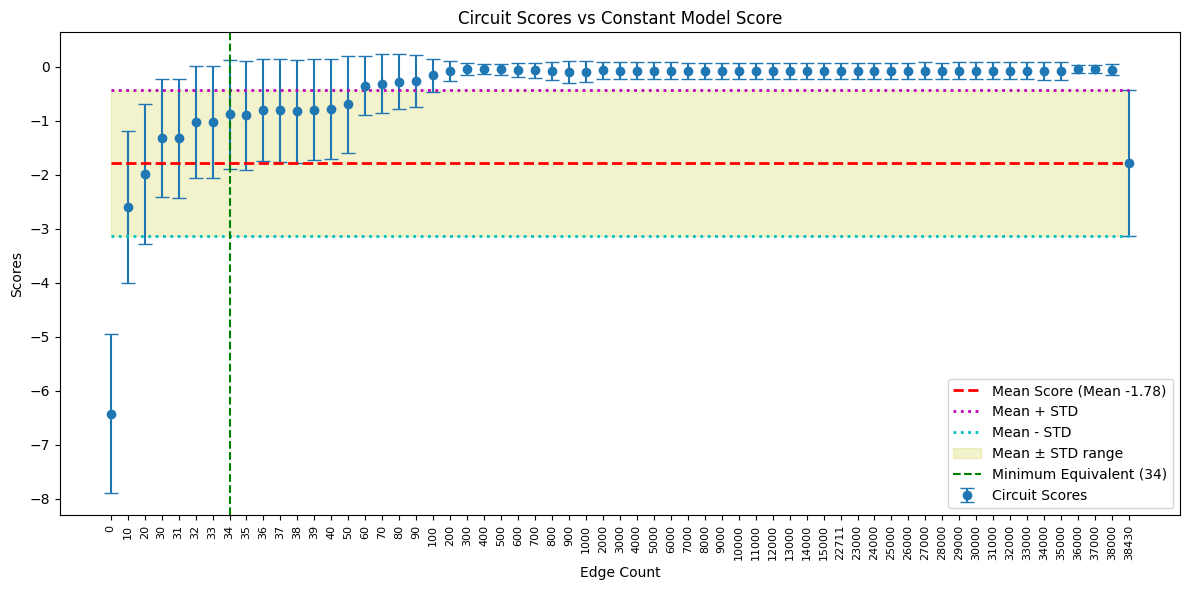

In [17]:
fig, ax = plot_circuit_and_model_scores(test_results, min_equiv)

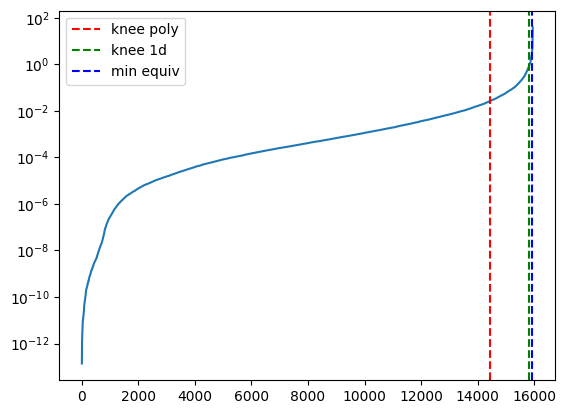

In [23]:
# plot attribution scores 
import numpy as np
edge_scores = np.flip(desc_prune_scores(attribution_scores, use_abs=use_abs).detach().cpu().numpy())
if not use_abs:
    edge_scores = edge_scores[edge_scores > 0]
kneedle_poly, kneedle_1d = compute_knees(edge_scores)
fig, ax = plot_edge_scores_and_knees(edge_scores, kneedle_poly, kneedle_1d, min_equiv)

In [24]:
round(len(edge_scores) - kneedle_poly.knee), round(len(edge_scores) - kneedle_1d.knee), min_equiv

(1526, 143, 34)

# Minimality Test

In [17]:
max_seq_idx = max([edge.seq_idx for edge in task.model.edges if edge.dest.name == "Resid End"])
max_seq_idx

29

## Build Graph Used To Sample Paths

In [18]:
from collections import defaultdict
from dataclasses import dataclass

@dataclass(frozen=True)
class SeqNode(Node):
    seq_idx: int | None = None

    def __repr__(self) -> str:
        return self.name + "_" + str(self.seq_idx)

    def __str__(self) -> str:
        return self.name + "_" + str(self.seq_idx)

def node_to_seq_node(node: Node, seq_idx: int) -> SeqNode:
    return SeqNode(
        name=node.name,
        module_name=node.module_name,
        layer=node.layer,
        head_idx=node.head_idx,
        head_dim=node.head_dim,
        seq_idx=seq_idx,
    )

def valid_node(node: SeqNode) -> bool:
    return node.layer < max_layer - 2 or node.seq_idx == last_seq_idx or node.name.endswith(("K", "V"))

last_seq_idx = max([src.seq_idx for src in task.model.edges])
srcs = task.model.srcs
dests = task.model.dests
max_layer = max([dest.layer for dest in dests])

# get edges by src and dest
edges_by_dest_idx: dict[NodeIdx, list[Edge]] = defaultdict(list)
edges_by_src_idx: dict[NodeIdx, list[Edge]] = defaultdict(list)
for edge in task.model.edges:
    edges_by_dest_idx[get_node_idx(edge.dest)].append(edge)
    edges_by_src_idx[get_node_idx(edge.src)].append(edge)

# sample path using topological sort + dynamic programming to get number of paths from each parent node, and sample according to proportion of paths 
start_node = next(src for src in task.model.srcs if src.name == "Resid Start")
dests_to_seq_dests: dict[DestNode, list[SeqNode]] = {
    dest: [node_to_seq_node(dest, seq_idx) for seq_idx in range(last_seq_idx + 1)]
    for dest in list(dests) + [start_node]
}

# construct graph and compute path counts
graph: dict[SeqNode: list[SeqNode]] = defaultdict(list[SeqNode])
nodes = set()
path_counts: dict[SeqNode, int] = defaultdict(int)

# sort dests by layer
for dest in tqdm(sorted(list(task.model.dests) + [start_node], key=lambda x: x.layer, reverse=True)):
    # construct seq node dest from dest for each seq_idx 
    seq_nodes = dests_to_seq_dests[dest]
    for seq_node in seq_nodes:
        # if dest is mlp or q and layer is >= max_layers - 2, skip  
        if not valid_node(seq_node):
            continue
        nodes.add(seq_node)
        # if dest is resid end, add to graph and set path count to 1, and skp
        if dest.name == "Resid End":
            graph[seq_node] = []
            path_counts[seq_node] = 1
            continue 
            # if dest is K, V 
        # get downstream edges from dest
        edges = edges_by_src_idx[get_node_idx(dest)]
        if dest.name.endswith(("K", "V")):
            # if dest.layer >= max_layer - 2 (last layer or two layers dependnign on whether attention and mlp are counted together)
            if dest.layer >= max_layer - 2:
                # convert edge dests to seq nodes with seq_idx = max_seq_idx
                child_dests = [dests_to_seq_dests[edge.dest][max_seq_idx] for edge in edges]
            else:
                # convert edge dests to all seq nodes
                child_dests = [seq_dest for edge in edges for seq_dest in dests_to_seq_dests[edge.dest]]
        # else (q or mlp)
        else: 
            # already checked if valid, but checking again
            assert valid_node(seq_node)
            # convet edge dests to all seq nodes with same seq_idx
            child_dests = [dests_to_seq_dests[edge.dest][seq_node.seq_idx] for edge in edges]
        # filter for valid child nodes
        graph[seq_node] = [child_dest for child_dest in child_dests if valid_node(child_dest)]
        path_counts[seq_node] = sum([path_counts[child_dest] for child_dest in child_dests])

In [19]:
end_graph = {k: v for k, v in graph.items() if k.layer > eg_min_layer}  # 21
end_graph_path_counts = {k: v for k, v in path_counts.items() if k.layer > 3}

start_graph = {k: [v for v in vs if v.layer < sg_max_layer] for k, vs in graph.items() if k.layer < sg_max_layer}
start_graph_path_counts = {k: v for k, v in path_counts.items() if k.layer < sg_max_layer}
sum([len(v) for v in end_graph.values()]), sum([len(v) for v in start_graph.values()])

(14640, 21600)

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def visualize_graph(graph, path_counts, sort_by_head: bool=True):
    # Create a new directed graph
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    for source, targets in graph.items():
        G.add_node(str(source), layer=source.layer, seq_idx=source.seq_idx, head_idx=source.head_idx)
        for target in targets:
            G.add_edge(str(source), str(target))

    # Set up the plot
    plt.figure(figsize=(24, 16))
    
    # Create a custom layout for the graph
    pos = {}
    seq_idx_set = sorted(set(data['seq_idx'] for _, data in G.nodes(data=True)))
    layer_set = sorted(set(data['layer'] for _, data in G.nodes(data=True)))  # No longer reversed
    
    # Group nodes by layer and seq_idx
    grouped_nodes = defaultdict(list)
    for node, data in G.nodes(data=True):
        grouped_nodes[(data['layer'], data['seq_idx'])].append((node, data))

    # Calculate layout
    column_width = 1.5  # Adjust this value to increase horizontal spacing
    row_height = 5  # Adjust this value to increase vertical spacing
    max_nodes_in_group = max(len(nodes) for nodes in grouped_nodes.values())
    
    for (layer, seq_idx), nodes in grouped_nodes.items():
        x = seq_idx_set.index(seq_idx) * column_width
        y = (len(layer_set) - 1 - layer_set.index(layer)) * row_height  # Invert y-axis
        
        # Sort nodes by head_idx (if available) or by node name
        if sort_by_head:
            sorted_nodes = sorted(nodes, key=lambda n: (n[1]['head_idx'] if n[1]['head_idx'] is not None else float('inf'), n[0]))
        else: # sort by Q, K, V, MLP
            sorted_nodes = sorted(nodes, key=lambda n: (n[0].split('_')[0].split('.')[-1]))
        
        # Position nodes in a vertical line within their layer and seq_idx group
        for i, (node, data) in enumerate(sorted_nodes):
            node_y = y - i * (row_height / (max_nodes_in_group + 1))  # Distribute nodes evenly within the row
            pos[node] = (x, node_y)

    # Draw the nodes
    node_size = 100  # Adjust as needed
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue')

    # Draw the edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, width=0.5, arrowsize=10)

    # Add labels to the nodes
    labels = {node: f"{node.split('_')[0]}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=6)

    # Add path counts as labels on the nodes (uncomment if needed)
    # path_count_labels = {str(node): f"Paths: {count}" for node, count in path_counts.items()}
    # nx.draw_networkx_labels(G, pos, path_count_labels, font_size=4, font_color='red')

    plt.title("Graph Visualization with Corrected Layer Spacing")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

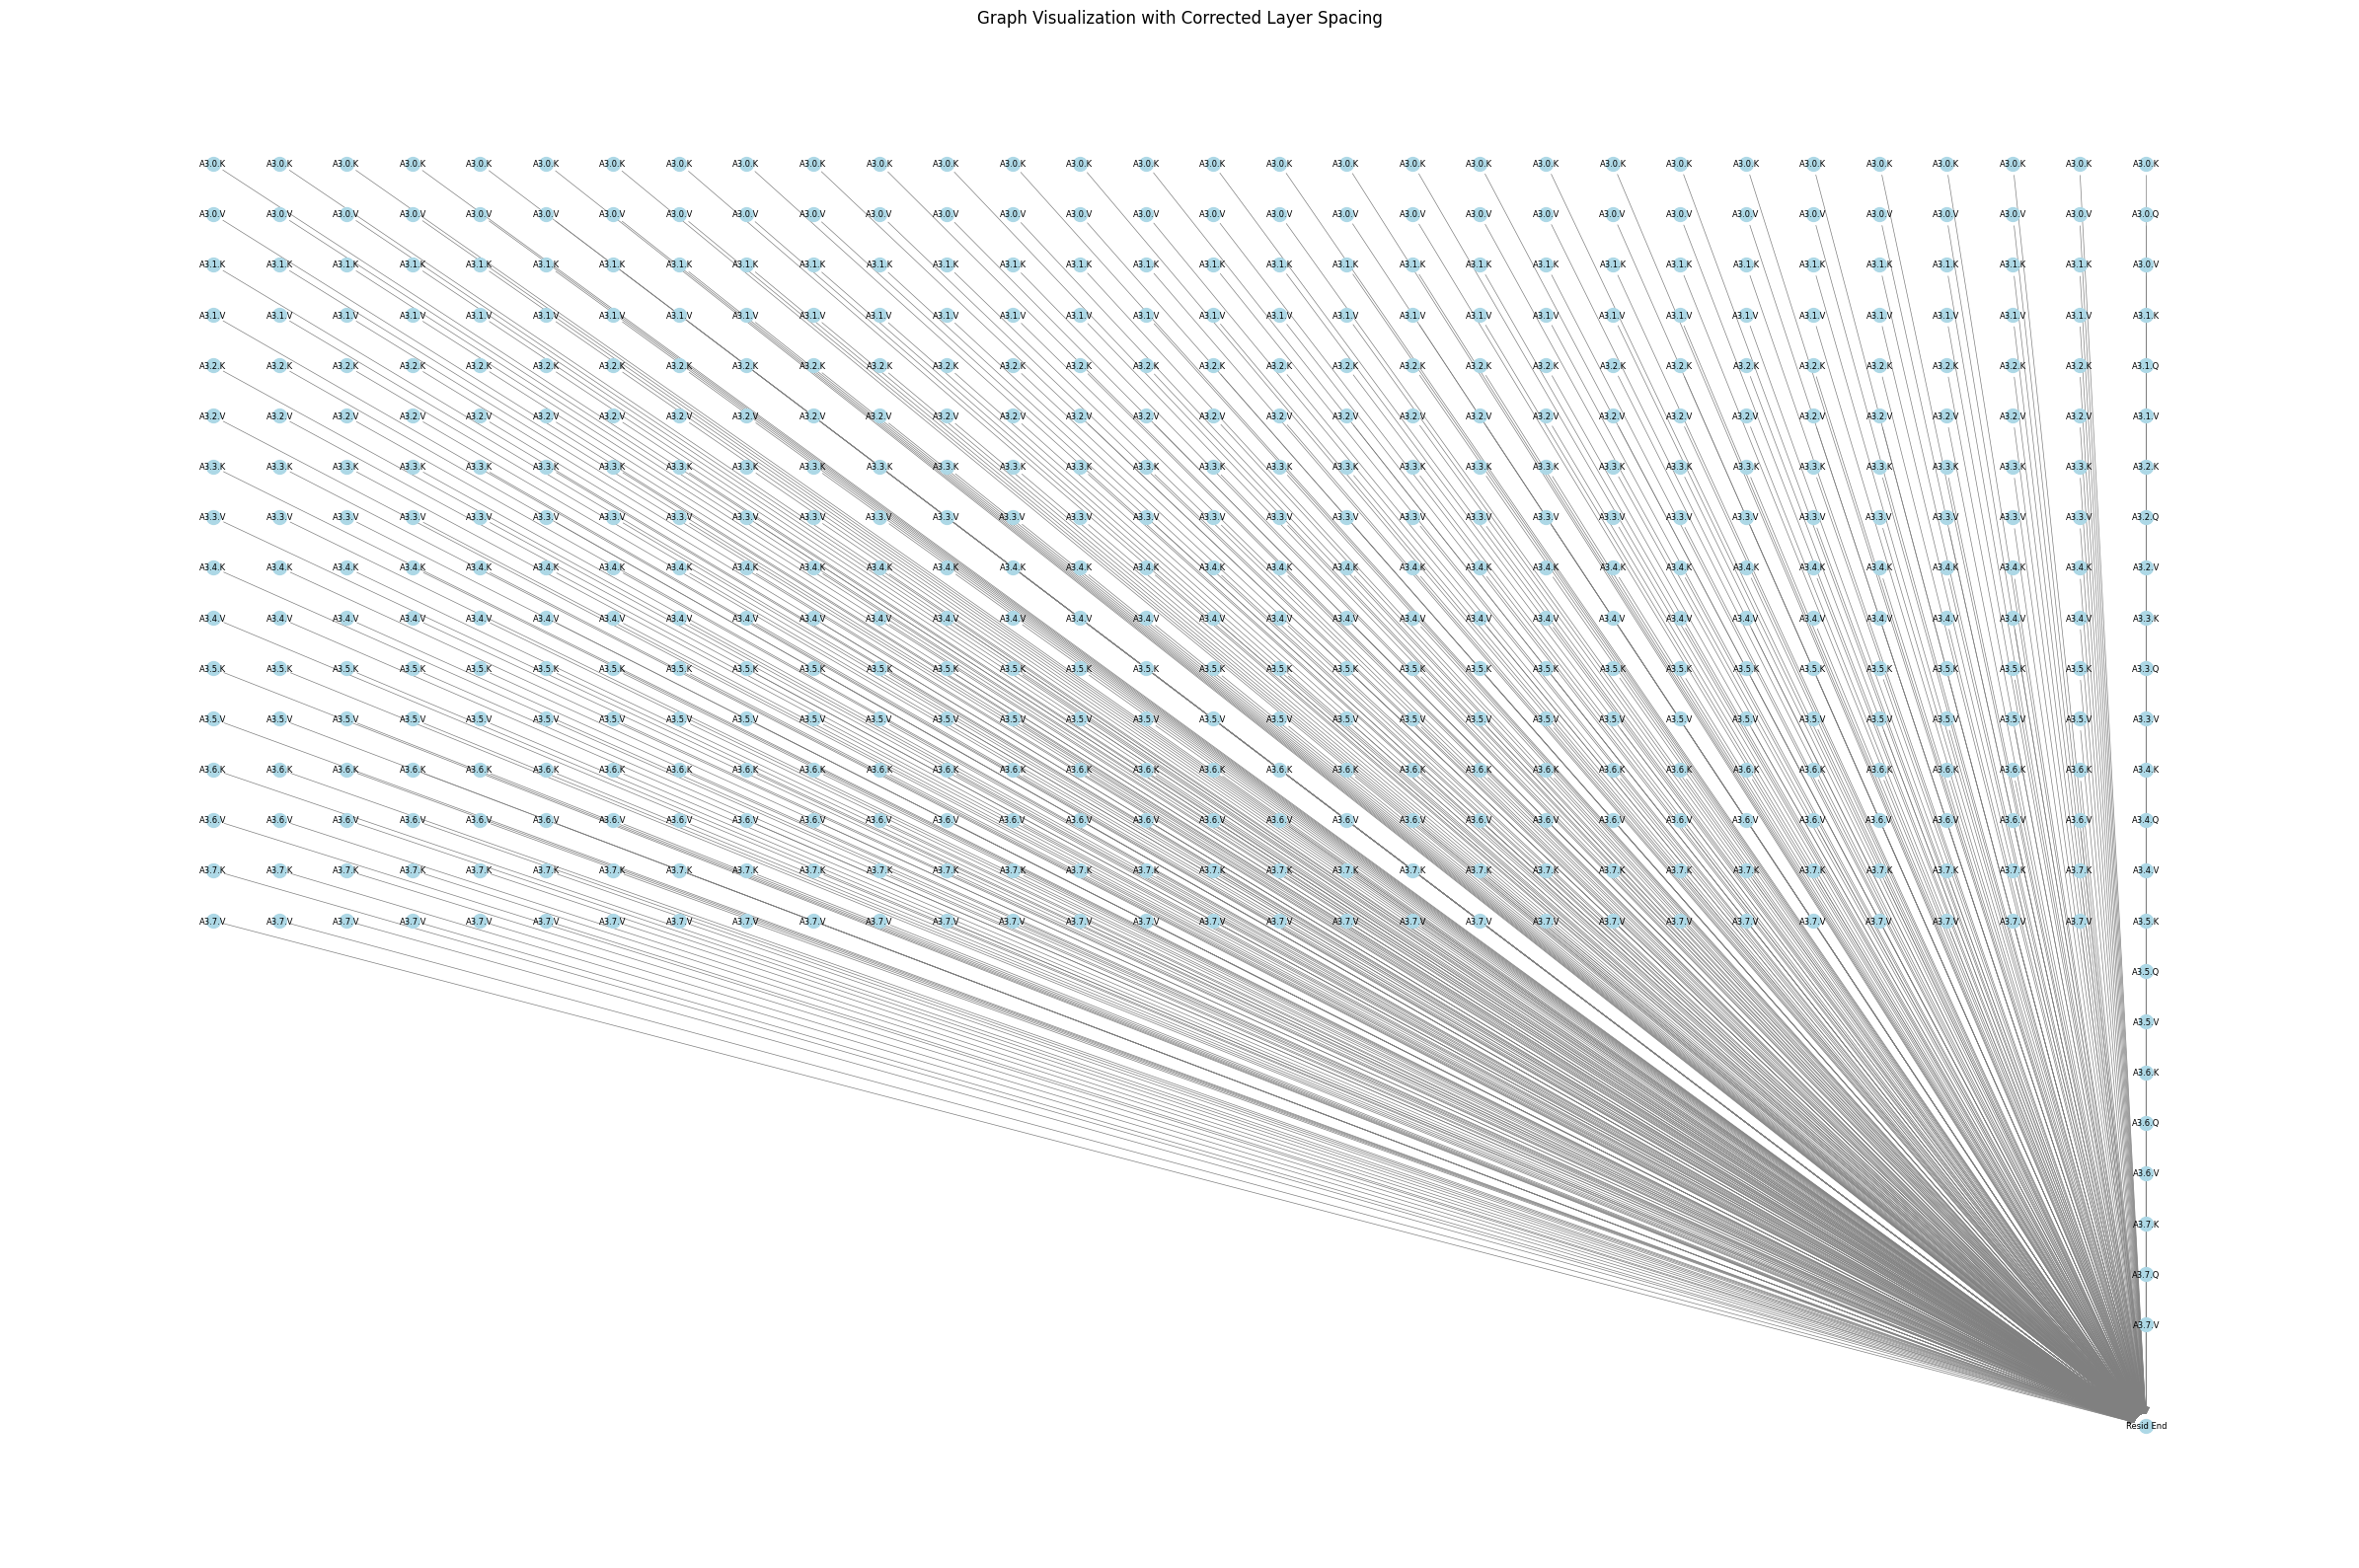

In [23]:
# end of graph
visualize_graph(end_graph, end_graph_path_counts)

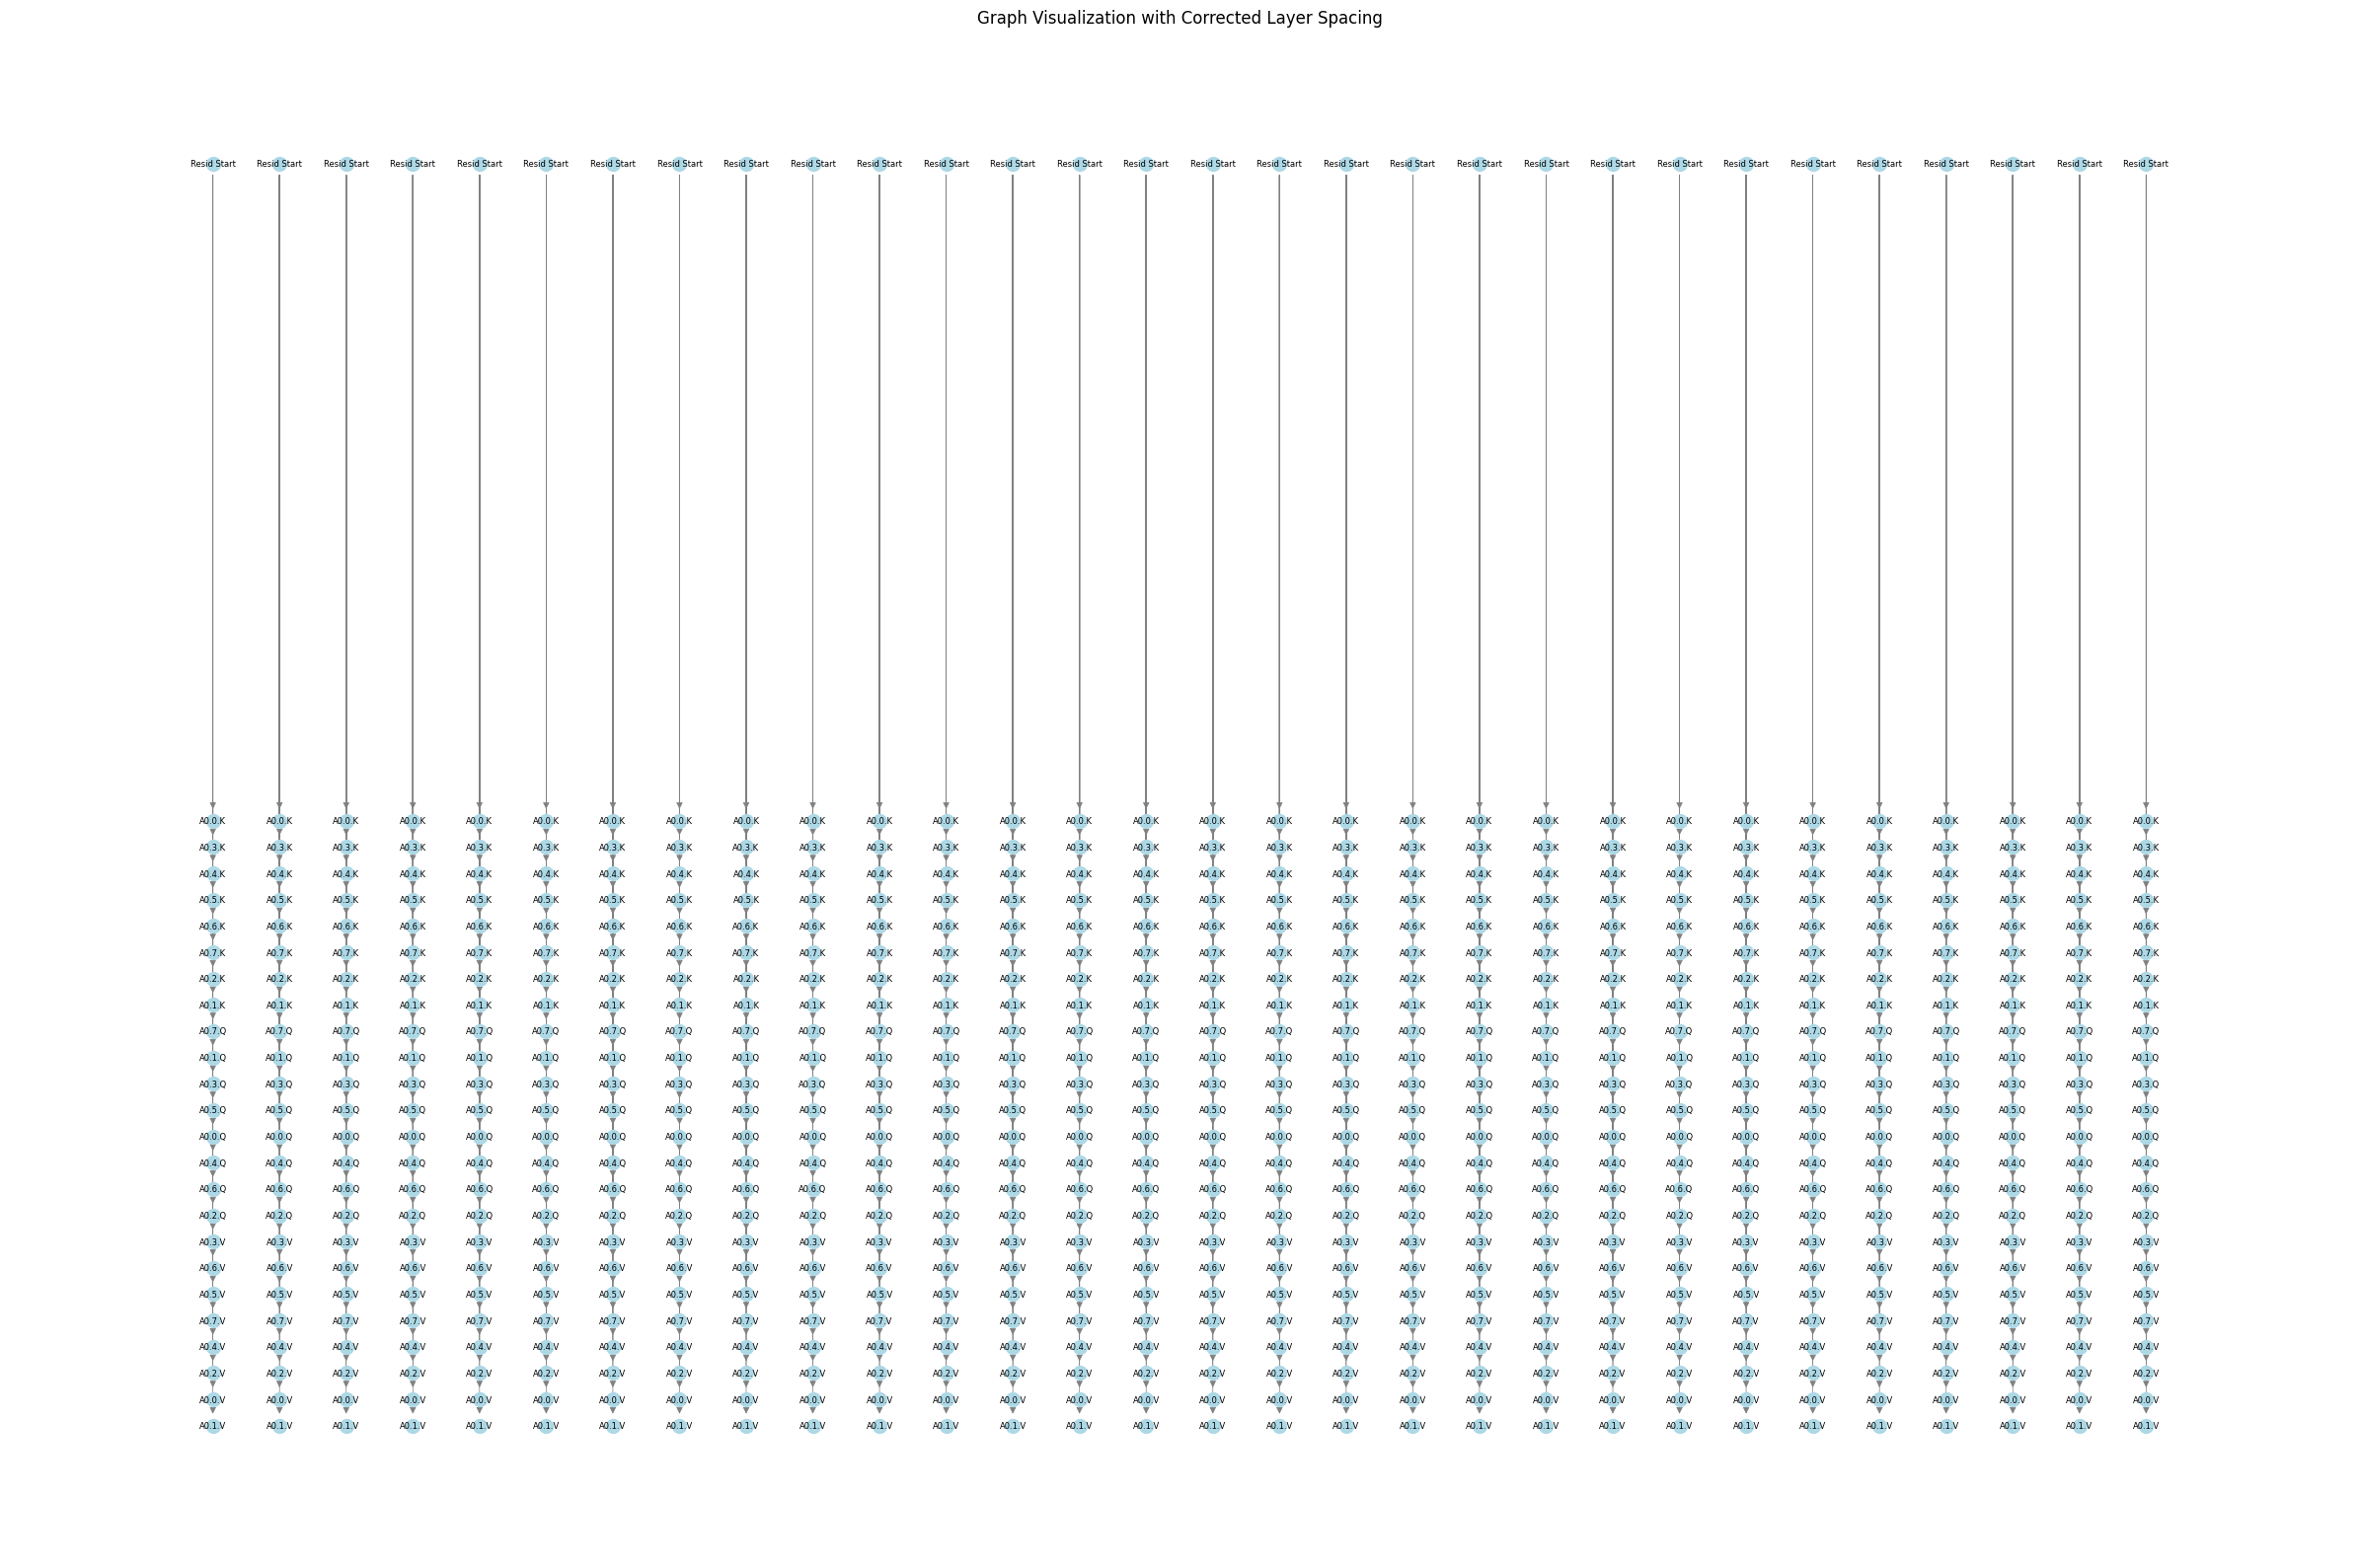

In [24]:
# start of graph
visualize_graph(start_graph, start_graph_path_counts, sort_by_head=False)

## Sample Paths

In [21]:
# sample path
sorted_nodes = sorted(list(nodes), key=lambda x: x.layer)
def sample_path():
    path = []
    current = random.choice(sorted_nodes[:max_seq_idx]) # resid starts
    path.append(current)
    while current.name != "Resid End":
        neighbors = graph[current]
        probs = [path_counts[neighbor] / path_counts[current] for neighbor in neighbors]
        current = random.choices(graph[current], weights=probs)[0] 
        path.append(current)
    return path 

In [22]:
# convert sequence dest nodes to edges 
dest_pairs_to_edges: dict[Tuple[int, int|None, str, int|None, int]: Edge] = {}
for edge in task.model.edges:
    dest_pairs_to_edges[(*get_node_idx(edge.src), edge.dest.name, edge.dest.head_idx, edge.seq_idx)] = edge

def dest_path_to_edge_path(dest_path: list[SeqNode]) -> list[Edge]:
    edge_path = []
    for i in range(len(dest_path) - 1):
        dest_src = dest_path[i]
        dest_dest = dest_path[i + 1]
        edge = dest_pairs_to_edges[(*get_node_idx(dest_src), dest_dest.name, dest_dest.head_idx, dest_dest.seq_idx)]
        edge_path.append(edge)
    return edge_path

In [23]:
# sample paths to be used for testing
tested_edges = edges_to_dest
tested_scores = dead_end_score_mask

n_paths = 256 
filtered_paths = []
for _ in tqdm(range(n_paths)):
    path = dest_path_to_edge_path(sample_path())
    while not any((edge not in tested_edges for edge in path)):
        path = dest_path_to_edge_path(sample_path())
    filtered_paths.append(path)

In [25]:
# sort edges
edge_scores = {edge: tested_scores[edge.dest.module_name][get_edge_idx(edge, tokens=task.token_circuit)] for edge in tested_edges}
tested_edges = sorted(edge_scores.keys(), key=lambda x: abs(edge_scores[x]), reverse=False)

## Run Minimality Tests

In [26]:
# run minimality test
min_test_results = minimality_test(
    task.model, 
    task.test_loader,
    dead_end_score_mask,
    tested_edges, 
    filtered_paths,
    min_equiv,
    ablation_type,
    grad_function,
    answer_function,
    threshold=threshold,
    tokens=task.token_circuit,
    alpha=alpha, 
    q_star=q_star
)

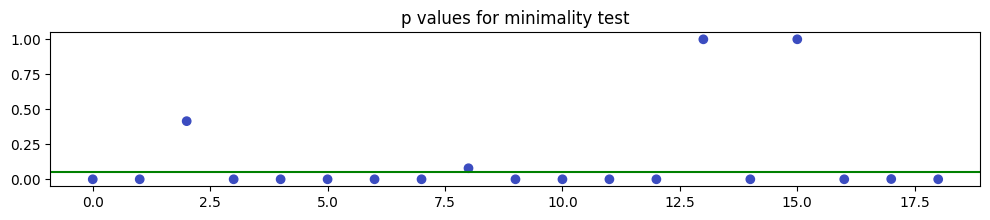

In [27]:
# plot p values as scatter plot
fig, ax = plot_p_values(min_test_results, tested_edges, edge_scores)


In [28]:
len(tested_edges)

19

(<Figure size 1200x200 with 1 Axes>,
 <Axes: title={'center': 'k for minimality test'}>)

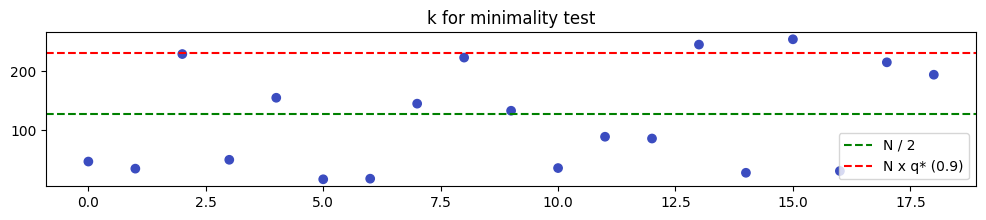

In [29]:
# plot frac of n 
batch_size = task.batch_size[1] if isinstance(task.batch_size, tuple) else task.batch_size
batch_count = task.batch_count[1] if isinstance(task.batch_count, tuple) else task.batch_count
plot_edge_k(min_test_results, tested_edges, edge_scores, batch_size * batch_count, q_star=q_star)


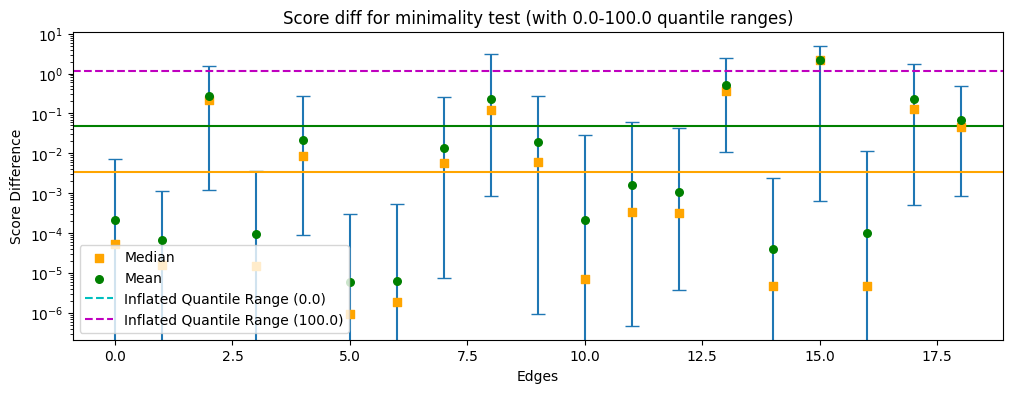

In [30]:
# plot average diff 
fit, ax = plot_score_quantiles(min_test_results, tested_edges, edge_scores, quantile_range=[0.00, 1.00])


## Independence Test
Test for completeness - if the circuit contains all the components required to perform the task, then the output of the complement should be independent of the original model

Null Hypothesis: Score of complement indepedendent of score of model

Hilbert Schmdit Indepednence Criterion - non-parametric measure of independence 


Ok background 

see https://jejjohnson.github.io/research_journal/appendix/similarity/hsic/

Hilbert-Schmidt Norm is just the Frobenious (L2) norm on matricies

Inner Product of Cross Covariance Matrix with itself is the same as the inner product of the auto-covariance matricies

So then we can apply separate kernel functions to the X's and Y's, compute the auto-covariance matrices, and then compute the squared inner 
product of the kernelized covariance matricies

...but there's some nuance in how you compute the covariance matricies from the kernelized data 
in particular we're assuming the kernel function has mean 0
- just remember to center it

still don't fully understand kernels/hilbert spaces


ok so the hypothesis paper defines it as the trace of K_{x,y}K_{x,y}, but can also define it as {K_x}{K_y}, b/c that holds in general for Cross Covariance and Auto Covariance 

Ok I'm confused why we would expect changing the order of Y to effect things...

intuition is that the trace gets the squared terms of correlations on the matching samples, so if there's correlation those should be larger than other permuations

so, if the null is that they're independent, we should expect a larger number of the permutations to be larger then the original ordering. If they are correlated, then 
fewer of the perumations should be greater, our p-value will be smaller, and thus we're more likely to reject the null



what value of $\rho$ do they use? maybe its just gaussian kernel?
"median pairwise distance betwen two samples




In [31]:
# ok, he're we're dealing with one dimensional scores, so we'll have a kerbnel fit to the scores of each (the data matrix) take the cross product to produce K_{xy}, then take the trace of the inner product
# first, we run the full model

dataloader = task.test_loader 
model = task.model
prune_scores = dead_end_score_mask

from auto_circuit.types import BatchOutputs
m_out: BatchOutputs = {}
for batch in dataloader:
    m_out[batch.key] = model(batch.clean)[model.out_slice]

# construct independence scores, applying abs value if use_abs is False (to ablate negative edges and only take complement on positives)
independence_scores = deepcopy(dead_end_score_mask)
if not use_abs:
    for k in independence_scores:
        independence_scores[k][independence_scores[k] < 0] = threshold + 1

# next, we run the complement of the circuit 
c_comp_out = dict(next(iter(run_circuits(
    model,
    dataloader,
    prune_scores=independence_scores,
    thresholds=[threshold], # not sure that's really right here
    prune_scores=prune_scores,
    patch_type=PatchType.EDGE_PATCH, # Edge patch is patching the edges in the circuit (not sure why?)
    ablation_type=ablation_type,
    reverse_clean_corrupt=False, 
    use_abs=True, # NOTE: this is cheating, but I think I can make a case for it - screen out edges of comparable magintiude 
).values())))

In [32]:
# then, we compute the scores 
score_func = get_score_func(grad_function, answer_function)
m_scores = []
c_comp_scores = []
for batch in dataloader:
    m_scores.append(score_func(m_out[batch.key], batch))
    c_comp_scores.append(score_func(c_comp_out[batch.key], batch))
m_scores = torch.cat(m_scores)[:, None].detach()
c_comp_scores = torch.cat(c_comp_scores)[:, None].detach()#.cpu().numpy()
sigma = torch.cdist(m_scores, c_comp_scores, p=2).median().item()

In [33]:

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import KernelCenterer
def hsic(X: np.ndarray, Y: np.ndarray, gamma: float) -> float:
    """(Hilbert-Schmidt Independence Criterion"""
    K_X = rbf_kernel(X, gamma=gamma)
    K_Y = rbf_kernel(Y, gamma=gamma)
    centerer = KernelCenterer()
    K_X_c = centerer.fit_transform(K_X)
    K_Y_c = centerer.fit_transform(K_Y)
    return np.trace(K_X_c @ K_Y_c)

In [34]:
# then we comptute the kernels on the scores using the rbf kernel with median sigma heuristic 
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import KernelCenterer

t_obs = hsic(m_scores.cpu().numpy(), c_comp_scores.cpu().numpy(), gamma=sigma)
t_obs


np.float32(224.30054)

In [35]:
 # then we compute the trace of the inner product of the cross product and itself (alternatively, the trace of the inner product of the covariance matrices)
# we store that value, then for b iterations 
B = 1000
t = 0
for b in range(B):
    # permutate the model scores 
    perm_m_scores = np.random.permutation(m_scores.cpu().numpy())
    # compute the new HSIC value 
    t_i = hsic(perm_m_scores, c_comp_scores.cpu().numpy(), gamma=sigma)
    # increment t with 1 if new value greater 
    t += t_obs < t_i
# p value = t / B
p_value = t / B
p_value, p_value < alpha # not independnet -> not complete

(np.float64(0.075), np.False_)